In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data_engage = pd.read_csv('takehome_user_engagement.csv')
data_engage = data_engage.set_index(pd.DatetimeIndex(data_engage['time_stamp']))
data_users = pd.read_csv('takehome_users.csv',encoding='latin-1')

data_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [2]:
data_engage.head()

,time_stamp,user_id,visited
time_stamp,,,
2014-04-22 03:53:30,2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2013-12-25 03:45:04,2,1


In [4]:
#groups by user, then date by week, and sums number of visits per week
grouped= data_engage.groupby('user_id').resample('1W').sum()
#removes weeks that were imputed for grouping but are NaN
grouped = grouped[grouped['user_id'].isnull()==False].drop('user_id',axis=1)
grouped.head(20)

visited
user_id time_stamp         
1       2014-04-27      1.0
2       2013-11-17      1.0
        2013-12-01      1.0
        2013-12-15      1.0
        2013-12-29      1.0
        2014-01-05      1.0
        2014-01-12      1.0
        2014-02-09      3.0
        2014-02-16      2.0
        2014-03-09      1.0
        2014-03-16      1.0
        2014-04-06      1.0
3       2013-03-24      1.0
4       2013-05-26      1.0
5       2013-01-27      1.0
6       2013-12-22      1.0
7       2012-12-23      1.0
10      2013-01-20      1.0
        2013-01-27      1.0
        2013-02-03      1.0

In [7]:
#tags weeks that had less than 3 visits for all users
active_users = grouped['visited']>=3
#Groups by users and sums up the number of weeks that had 3 or more visits
active_users = active_users.groupby(level=0).apply(np.sum)
#removes users with no weeks that had 3 or more visits
active_users = active_users[active_users!=0]
active_users = pd.DataFrame(active_users,index=active_users.index)
active_users.columns = ['Active Weeks']
active_users.head(5)

,Active Weeks
user_id,
2,1
10,52
20,1
33,1
42,68


In [9]:
act_user_data = active_users.merge(data_users,left_index=True,right_on='object_id',how='inner')
act_user_data['Active']=1
act_user_data.head()

,Active Weeks,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,Active
1,1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
9,52,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,1
19,1,20,2014-03-06 11:46:38,Helms Mikayla,lqyvjilf@uhzdq.com,SIGNUP,1.401364e+09,0,0,58,NaN,1
32,1,33,2014-03-11 06:29:09,Araujo José,JoseMartinsAraujo@cuvox.de,GUEST_INVITE,1.401518e+09,0,0,401,79.0,1
41,68,42,2012-11-11 19:05:07,Pinto Giovanna,GiovannaCunhaPinto@cuvox.de,SIGNUP,1.401045e+09,1,0,235,NaN,1


In [21]:
#Pull data on Active users
act_user_data = active_users.merge(data_users,left_index=True,right_on='object_id',how='inner')
act_user_data['Active']=1

#Add Active column to origional Data
data_users['Active']=int(0)
data_users.iloc[list(act_user_data.index),10]=1
model_data = data_users.set_index('object_id').sort_index()

#Prep data for modeling by removing unecessary features
model_data = model_data.drop([ 'name', 'email','last_session_creation_time',],axis=1)
date_feature = model_data.pop('creation_time')
model_data.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,Active
object_id,,,,,,
1,GUEST_INVITE,1,0,11,10803.0,0
2,ORG_INVITE,0,0,1,316.0,1
3,ORG_INVITE,0,0,94,1525.0,0
4,GUEST_INVITE,0,0,1,5151.0,0
5,GUEST_INVITE,0,0,193,5240.0,0


In [22]:
model_data['invited_by_user_id'] = model_data['invited_by_user_id'].fillna(0)
model_data['invited_by_user_id'] = model_data['invited_by_user_id'].apply(
        lambda x: 1 if x!=0 else 0)
model_data = pd.get_dummies(data=model_data,columns=['creation_source'])

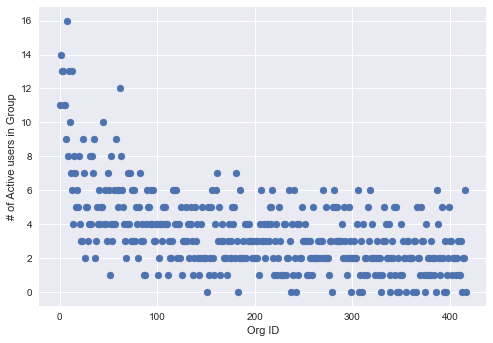

In [23]:
import seaborn
org = model_data.groupby('org_id').sum()
plt.scatter(org.index,org.Active)
plt.ylabel('# of Active users in Group')
plt.xlabel('Org ID')
plt.show()

In [24]:
org_cata = []
for i in model_data['org_id']:
    cata = org.loc[i,'Active']
    org_cata.append(cata)
model_data['org_id'] = org_cata

model_data = pd.get_dummies(data=model_data,columns=['org_id'])
model_data.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,Active,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,org_id_0,...,org_id_6,org_id_7,org_id_8,org_id_9,org_id_10,org_id_11,org_id_12,org_id_13,org_id_14,org_id_16
object_id,,,,,,,,,,,,,,,,,,,,,
1,1,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# Modeling --------------------------------
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV,train_test_split

y = model_data.pop('Active')
x = model_data

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.25,random_state=42)

In [30]:
#GradientBoostingClassifier ------------------
graboost = GradientBoostingClassifier(max_features='sqrt')
parametergra = {'n_estimators':[50,55,45],'learning_rate':[.05,.01],
              'max_depth':[3,4]}
grid1 = GridSearchCV(estimator=graboost,param_grid=parametergra,
                     scoring='accuracy',cv=5)
grid1.fit(x_train,y_train)
best_para_gra = grid1.best_params_
best_acc_gra = grid1.best_score_

print('The Tuned Paratmers :\n',best_para_gra,'\nAchieved %s Percent Accuracy' %(best_acc_gra*100))

The Tuned Paratmers :
 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50} 
Achieved 88.0 Percent Accuracy


In [35]:
gbm = GradientBoostingClassifier(max_features='sqrt',
                                 n_estimators=50,learning_rate=.05,max_depth= 3)
gbm.fit(x_train,y_train)
feature_coef = pd.DataFrame(gbm.feature_importances_).transpose()
feature_coef.columns = list(model_data.columns)
feature_coef.index = ['GBM'] 
feature_coef.transpose().sort_values(by='GBM',ascending=False)

,GBM
org_id_0,0.166165
creation_source_PERSONAL_PROJECTS,0.160603
org_id_5,0.137471
org_id_1,0.109795
org_id_11,0.095873
org_id_6,0.091491
creation_source_GUEST_INVITE,0.051692
org_id_12,0.043416
creation_source_SIGNUP_GOOGLE_AUTH,0.024827
creation_source_ORG_INVITE,0.023792
